# LSTM

In [1]:
# imports
import time
import os
import optuna
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, balanced_accuracy_score, precision_score, f1_score, recall_score, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from nltk.corpus import stopwords
import re
import nltk
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')

C:\Users\User\AppData\Local\Temp/ipykernel_2944/2352934017.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## 1. Data loading and exploration

In [2]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')
amazon_reviews_df = pd.read_csv('data/cleaned_amazon_reviews.csv')

In [3]:
ag_news_train_df.shape

(120000, 3)

In [4]:
ag_news_test_df.shape

(7600, 3)

In [5]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [6]:
amazon_reviews_df.shape

(17340, 4)

In [7]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [8]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

<AxesSubplot:>

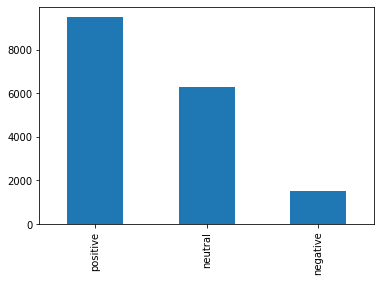

In [9]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

Unbalanced target

<AxesSubplot:>

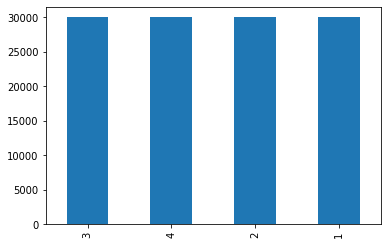

In [10]:
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

Balanced target

#### Distribution of review lengths

(array([1.4993e+04, 1.8380e+03, 3.4300e+02, 8.3000e+01, 5.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0. ,  57.1, 114.2, 171.3, 228.4, 285.5, 342.6, 399.7, 456.8,
        513.9, 571. ]),
 <BarContainer object of 10 artists>)

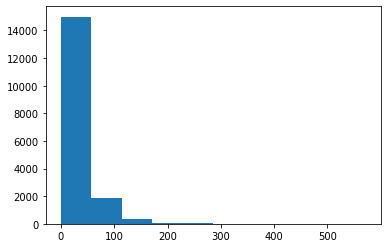

In [11]:
plt.hist(amazon_reviews_df.cleaned_review_length)

#### Distribution of the news article lengths

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <BarContainer object of 10 artists>)

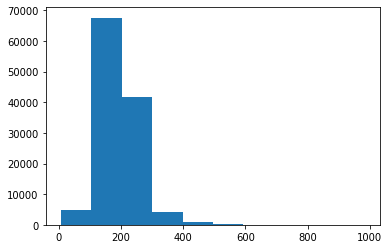

In [12]:
plt.hist(ag_news_train_df.Description.str.len())

In [13]:
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

#### Removing NaNs

In [14]:
amazon_reviews_df.dropna(inplace=True)

## 2. Train/Val/Test split

In [15]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

In [16]:
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                   y_amazon_reviews,
                                                                                   random_state=42,
                                                                                   test_size=0.2)

In [17]:
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                     y_train_reviews,
                                                                                     random_state=42,
                                                                                     test_size = 0.25)

### Splitting ag news into X and y's

Merging Title and Description into one field, "Text"

In [18]:
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [19]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [20]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

In [21]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size = 0.25)

In [22]:
# split the data sets accordignly, so we can perform hyperparameter tuning somewhat successfully

np.random.seed(42)
reviews_train_idx = np.random.choice(y_train_reviews.shape[0], 
                                     replace=False, size=y_train_reviews.shape[0]//2)
news_train_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//8)

X_train_reviews_half = X_train_reviews.iloc[reviews_train_idx,:]
y_train_reviews_half = y_train_reviews.iloc[reviews_train_idx]
X_train_news_eight = X_train_news.iloc[news_train_idx]
y_train_news_eight = y_train_news.iloc[news_train_idx]

In [23]:
# checking if models are saved

best_model_nn_reviews_is_saved = os.path.exists('models/best_model_lstm_reviews.sav')
best_model_nn_news_is_saved = os.path.exists('models/best_model_lstm_news.sav')

## 3. Model development - LSTM

### 3.1. Reviews data set

In [24]:
# setting the vocabulary and sentence length
voc_size = 5000
sent_length = 40
embedding_vector_features = 40

In [25]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

In [26]:
X_train.head()

,cleaned_review,cleaned_review_length,review_score
11652,i do love this product but bought it think had...,19,4.0
7240,this mouse works very well and has very long b...,16,5.0
16483,just like described very pleased we also had a...,45,5.0
13353,our year old son asked for this headset for hi...,44,5.0
6024,nice looking mouse beautiful colors and comfor...,69,5.0


In [27]:
def preprocessing_reviews(X, y, sent_length):
    X.drop(['cleaned_review_length', 'review_score'], axis=1, inplace=True)
    corpus = X['cleaned_review'].values.tolist()
    onehot_repr = [one_hot(words, voc_size) for words in corpus] 
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length)
        
    y = pd.get_dummies(y)
    
    X = np.array(embedded_docs)
    y = np.array(y)
    
    return (X, y)

In [28]:
X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

#### 3.1.1. Reviews, LSTM model 1. - base

In [29]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 256,703
Trainable params: 256,703
Non-trainable params: 0
_________________________________________________________________
None


The results show that the model is overfitting the training data and not generalizing well to the validation data. This can be seen from the increasing difference between training accuracy and validation accuracy as the number of epochs increases.

The training accuracy increases up to 95.6% while the validation accuracy only reaches 82.15%. This suggests that the model is memorizing the training data rather than learning the underlying patterns that can be generalized to the validation set.

The loss is also decreasing on the training set, but increasing on the validation set. This further supports the overfitting issue.


To address the overfitting issue, we will try using regularization techniques like dropout, or simplifying the model architecture.

In [30]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

326/326 [==============================] - 18s 47ms/step - loss: 0.6580 - accuracy: 0.7118


In [31]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

reviews_m1_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m1_results['train_time'] = train_time
reviews_m1_results['test_time'] = test_time
reviews_m1_results = pd.DataFrame.from_dict(reviews_m1_results)
reviews_m1_results.to_csv('results/lstm/reviews/model_1.csv')
pickle.dump(model, open('models/lstm/reviews/model_1.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://db04533e-612a-43b3-b277-ccc410bd6660/assets


INFO:tensorflow:Assets written to: ram://db04533e-612a-43b3-b277-ccc410bd6660/assets


In [33]:
reviews_m1_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.542453,0.684868,0.909562,0.788639,0.712294,0.795359,17.70314,2.335842
recall,0.365079,0.834135,0.828871,0.788639,0.676028,0.788639,17.70314,2.335842
f1-score,0.436433,0.752168,0.867344,0.788639,0.685315,0.786757,17.70314,2.335842
support,315.000000,1248.000000,1905.000000,0.788639,3468.000000,3468.000000,17.70314,2.335842


The test accuracy is 0.827 which is very similar to the validation results, therefore we will try to add dropout layers, or simplify the model architecture.

We are using accuracy at the moment, we will later on focus on more metrics, and see in greated details how to best optimize the model.

#### 3.1.2. Reviews, LSTM model 2. - base with dropout

In [34]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 40, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 256,703
Trainable params: 256,703
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

326/326 [==============================] - 13s 29ms/step - loss: 0.7034 - accuracy: 0.6827 - recall: 0.5753 - precision: 0.7406


In [38]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
# y_test = np.argmax(y_test, axis = 1)

reviews_m2_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m2_results['train_time'] = train_time
reviews_m2_results['test_time'] = test_time
reviews_m2_results = pd.DataFrame.from_dict(reviews_m2_results)
reviews_m2_results.to_csv('results/lstm/reviews/model_2.csv')
pickle.dump(model, open('models/lstm/reviews/model_2.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://c3eab251-75aa-4ec5-99c1-104b0a8816c2/assets


INFO:tensorflow:Assets written to: ram://c3eab251-75aa-4ec5-99c1-104b0a8816c2/assets


In [39]:
reviews_m2_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.417910,0.689147,0.875203,0.761822,0.660754,0.766713,12.59139,2.243873
recall,0.444444,0.712340,0.846719,0.761822,0.667834,0.761822,12.59139,2.243873
f1-score,0.430769,0.700552,0.860726,0.761822,0.664016,0.764032,12.59139,2.243873
support,315.000000,1248.000000,1905.000000,0.761822,3468.000000,3468.000000,12.59139,2.243873


After adding two dropout layers with the probability of 0.3, we get an accuracy of 0.828 which isn't an improvement really. We will now try to change the model architecture, and see what we can get.

We will change the voc_size and the sent_length to see if that can make the results better.

#### 3.1.3. Reviews, LSTM model 3. - dropout and voc and sent length changed

In [40]:
# setting the vocabulary and sentence length
voc_size = 10000
sent_length = 100
embedding_vector_features = 60

In [41]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [42]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 60)           600000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              128800    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 3)                 603       
                                                                 
Total params: 729,403
Trainable params: 729,403
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

326/326 [==============================] - 47s 132ms/step - loss: 0.6417 - accuracy: 0.7180


In [47]:
# adjust the y_pred and the y_test
# y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

reviews_m3_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m3_results['train_time'] = train_time
reviews_m3_results['test_time'] = test_time
reviews_m3_results = pd.DataFrame.from_dict(reviews_m3_results)
reviews_m3_results.to_csv('results/lstm/reviews/model_3.csv')
pickle.dump(model, open('models/lstm/reviews/model_3.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://5e72dc42-998f-4648-84e1-9e9e1c6ee9c7/assets


INFO:tensorflow:Assets written to: ram://5e72dc42-998f-4648-84e1-9e9e1c6ee9c7/assets


In [49]:
reviews_m3_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.752577,0.725437,0.901857,0.822088,0.793290,0.824811,47.43676,5.919207
recall,0.231746,0.863782,0.892388,0.822088,0.662639,0.822088,47.43676,5.919207
f1-score,0.354369,0.788588,0.897098,0.822088,0.680018,0.808753,47.43676,5.919207
support,315.000000,1248.000000,1905.000000,0.822088,3468.000000,3468.000000,47.43676,5.919207


The best result is 84 % accuracy, which is an improvement, it mostly happened because we increased the size of the features, and the sent length, and the voc size, so it managed to capture more information. Of, course it does train longer than but that is the trade off we must accept.

#### 3.1.4. Reviews, Hyperparameter tuning

In [79]:
X_train = X_train_reviews_half.copy()
y_train = y_train_reviews_half.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [80]:
def create_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=hp.Int('voc_size', 5000, 20000, step=2500),
        output_dim=hp.Int('embedding_size', 32, 128, 32),
        input_length = 100))    
    model.add(Bidirectional(LSTM(units=hp.Int('LSTM_units', 32, 128, 32))))
    model.add(Dense(units=hp.Int('dense_units', 10, 50, 10), activation=hp.Choice('dense_activation', values=['relu', 'sigmoid', 'tanh'])))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss=CategoricalCrossentropy(),
        metrics=[Accuracy()]
    )
    return model

In [81]:
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='tuning',
    project_name='movie_review_sentiment_analysis'
)

INFO:tensorflow:Reloading Tuner from tuning\movie_review_sentiment_analysis\tuner0.json


INFO:tensorflow:Reloading Tuner from tuning\movie_review_sentiment_analysis\tuner0.json


In [82]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [83]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hyperparameters)

In [84]:
best_hyperparameters.values

{'voc_size': 7500,
 'embedding_size': 64,
 'sent_length': 90,
 'LSTM_units': 64,
 'dense_units': 50,
 'dense_activation': 'relu',
 'learning_rate': 0.01}

In [ ]:
# fitting the best model

In [85]:
# setting the vocabulary and sentence length
voc_size = 7500
sent_length = 90
embedding_vector_features = 64

In [86]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [87]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.01), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 90, 64)            480000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 50)                6450      
                                                                 
 dense_9 (Dense)             (None, 3)                 153       
                                                                 
Total params: 552,651
Trainable params: 552,651
Non-trainable params: 0
_________________________________________________________________
None


In [88]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

326/326 [==============================] - 39s 104ms/step - loss: 0.6452 - accuracy: 0.7239


In [89]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

reviews_m4_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m4_results['train_time'] = train_time
reviews_m4_results['test_time'] = test_time
reviews_m4_results = pd.DataFrame.from_dict(reviews_m4_results)
reviews_m4_results.to_csv('results/lstm/reviews/model_4.csv')
pickle.dump(model, open('models/lstm/reviews/model_4.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://0a2f7b57-d3ff-4ae9-b8d4-14f6df585d15/assets


INFO:tensorflow:Assets written to: ram://0a2f7b57-d3ff-4ae9-b8d4-14f6df585d15/assets


In [90]:
reviews_m4_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.633333,0.706897,0.904891,0.8094,0.748374,0.808975,39.3978,4.347106
recall,0.241270,0.854167,0.874016,0.8094,0.656484,0.809400,39.3978,4.347106
f1-score,0.349425,0.773585,0.889186,0.8094,0.670732,0.798559,39.3978,4.347106
support,315.000000,1248.000000,1905.000000,0.8094,3468.000000,3468.000000,39.3978,4.347106


### 3.1.2. Model comparison

In [91]:
reviews_m1_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.542453,0.684868,0.909562,0.788639,0.712294,0.795359,17.70314,2.335842
recall,0.365079,0.834135,0.828871,0.788639,0.676028,0.788639,17.70314,2.335842
f1-score,0.436433,0.752168,0.867344,0.788639,0.685315,0.786757,17.70314,2.335842
support,315.000000,1248.000000,1905.000000,0.788639,3468.000000,3468.000000,17.70314,2.335842


In [92]:
reviews_m2_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.417910,0.689147,0.875203,0.761822,0.660754,0.766713,12.59139,2.243873
recall,0.444444,0.712340,0.846719,0.761822,0.667834,0.761822,12.59139,2.243873
f1-score,0.430769,0.700552,0.860726,0.761822,0.664016,0.764032,12.59139,2.243873
support,315.000000,1248.000000,1905.000000,0.761822,3468.000000,3468.000000,12.59139,2.243873


In [93]:
reviews_m3_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.752577,0.725437,0.901857,0.822088,0.793290,0.824811,47.43676,5.919207
recall,0.231746,0.863782,0.892388,0.822088,0.662639,0.822088,47.43676,5.919207
f1-score,0.354369,0.788588,0.897098,0.822088,0.680018,0.808753,47.43676,5.919207
support,315.000000,1248.000000,1905.000000,0.822088,3468.000000,3468.000000,47.43676,5.919207


In [94]:
reviews_m4_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.633333,0.706897,0.904891,0.8094,0.748374,0.808975,39.3978,4.347106
recall,0.241270,0.854167,0.874016,0.8094,0.656484,0.809400,39.3978,4.347106
f1-score,0.349425,0.773585,0.889186,0.8094,0.670732,0.798559,39.3978,4.347106
support,315.000000,1248.000000,1905.000000,0.8094,3468.000000,3468.000000,39.3978,4.347106


Conclusion

### 3.2. News data set

In [95]:
### helper functions

# Tokenize the sentence into words
lemmatizer = WordNetLemmatizer()

def lemmetize_it(sentence):
    words = nltk.word_tokenize(sentence)
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    lemmas_str = ' '.join(lemmas)
    return lemmas_str

def clean_news_data(X):    
    X = X.apply(lambda x: " ".join(x.lower() for x in x.split()))
    X = X.str.replace('[^\w\s]','', regex=True)
    
    stop = stopwords.words('english')
    X = X.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    # Create a WordNet lemmatizer object
    lemmatizer = WordNetLemmatizer()
    
    X = X.apply(lemmetize_it)
    
    return(X)

def preprocessing_news(X, y, sent_length):
    corpus = X.values.tolist()
    onehot_repr = [one_hot(words, voc_size) for words in corpus] 
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length)
        
    y = pd.get_dummies(y)
    
    X = np.array(embedded_docs)
    y = np.array(y)
    
    return (X, y)

In [96]:
X_train = X_train_news.copy()
y_train = y_train_news.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()
X_valid = X_valid_news.copy()
y_valid = y_valid_news.copy()

X_train = clean_news_data(X_train)
X_valid = clean_news_data(X_valid)
X_test = clean_news_data(X_test)

### 3.2.1. News, LSTM model 1 - base

In [97]:
# setting the vocabulary and sentence length
voc_size = 10000
sent_length = 150
embedding_vector_features = 50

In [98]:
X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_news(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [99]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(4, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 50)           500000    
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dense_10 (Dense)            (None, 4)                 404       
                                                                 
Total params: 560,804
Trainable params: 560,804
Non-trainable params: 0
_________________________________________________________________
None


In [100]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

2813/2813 [==============================] - 476s 169ms/step - loss: 0.3876 - accuracy: 0.8639


In [101]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

news_m1_results = classification_report(y_test, y_pred, output_dict=True)

news_m1_results['train_time'] = train_time
news_m1_results['test_time'] = test_time
news_m1_results = pd.DataFrame.from_dict(news_m1_results)
news_m1_results.to_csv('results/lstm/news/model_1.csv')
pickle.dump(model, open('models/lstm/news/model_1.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://220bccd2-3fbd-4c9b-9165-c79345212dc1/assets


INFO:tensorflow:Assets written to: ram://220bccd2-3fbd-4c9b-9165-c79345212dc1/assets


In [102]:
news_m1_results

,0,1,2,3,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.917033,0.942097,0.880022,0.835345,0.892368,0.893624,0.893624,476.462747,15.842448
recall,0.878421,0.950526,0.830000,0.910526,0.892368,0.892368,0.892368,476.462747,15.842448
f1-score,0.897312,0.946293,0.854280,0.871317,0.892368,0.892300,0.892300,476.462747,15.842448
support,1900.000000,1900.000000,1900.000000,1900.000000,0.892368,7600.000000,7600.000000,476.462747,15.842448


Based on the provided results of the LSTM model, it appears to be a good starting point for the news classification task. The training accuracy increased with each epoch, while the validation accuracy remained consistently high, suggesting that the model is generalizing well to new data. The validation loss did not increase significantly over the three epochs, indicating that the model is not overfitting. Overall, the model achieved an accuracy of 85.5% on the validation data.

The test accuracy is 86.9% which is very similar to the validation results, therefore we will try to add dropout layers, or simplify the model architecture.

#### 3.1.2. LSTM model 2. - dropout and voc and sent length changed

In [105]:
# setting the vocabulary and sentence length
voc_size = 20000
sent_length = 200
embedding_vector_features = 100

In [106]:
X_train = X_train_news.copy()
y_train = y_train_news.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()

X_train = clean_news_data(X_train)
X_test = clean_news_data(X_test)

X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [107]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(4, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 100)          2000000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 4)                 804       
                                                                 
Total params: 2,161,604
Trainable params: 2,161,604
Non-trainable params: 0
_________________________________________________________________
None


In [108]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

2813/2813 [==============================] - 1158s 410ms/step - loss: 0.3505 - accuracy: 0.8797


In [109]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

news_m2_results = classification_report(y_test, y_pred, output_dict=True)

news_m2_results['train_time'] = train_time
news_m2_results['test_time'] = test_time
news_m2_results = pd.DataFrame.from_dict(news_m2_results)
news_m2_results.to_csv('results/lstm/news/model_2.csv')
pickle.dump(model, open('models/lstm/news/model_2.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://e042641f-681a-4aa1-a5c8-90f2310b6e63/assets


INFO:tensorflow:Assets written to: ram://e042641f-681a-4aa1-a5c8-90f2310b6e63/assets


In [110]:
news_m2_results

,0,1,2,3,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.914271,0.923077,0.888704,0.882945,0.902763,0.902249,0.902249,1158.448492,32.372607
recall,0.903684,0.985263,0.844737,0.877368,0.902763,0.902763,0.902763,1158.448492,32.372607
f1-score,0.908947,0.953157,0.866163,0.880148,0.902763,0.902104,0.902104,1158.448492,32.372607
support,1900.000000,1900.000000,1900.000000,1900.000000,0.902763,7600.000000,7600.000000,1158.448492,32.372607


In [ ]:
# best result is 87 % accuracy without hyperparameter tuning